In [1]:
#@title Imports
%%capture
!pip install ortools
from six.moves import xrange
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
from csv import reader
import requests, os, zipfile
import numpy as np
from scipy.spatial.distance import pdist, squareform
from math import radians, cos, sin, asin, sqrt, atan2

In [2]:
#@title Dataset Download
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)
    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)
    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)


dataset = '/content/_data.xlsx'
download_file_from_google_drive('1wRHyl4APmUkfpxdfio5KBl9osR_vTeuy', dataset)


In [3]:
#@title Vehicle Class
class Vehicle():
    def __init__(self):
        self._capacity = 22000
        self.routes = []
        self.time_min = []
        self.time_max = []
        self.load = []

    @property
    def capacity(self):
        return self._capacity

    def routes(self):
        return self.routes

In [4]:
# @title Data class
class DataProblem():
    @property
    def num_vehicles(self):
        """Gets number of vehicles"""
        return self._num_vehicles

    """Stores the data for the problem"""

    def __init__(self):
        """Initializes the data for the problem"""
        print("Data Model:")
        self._vehicle = Vehicle()
        self._num_vehicles = 5
        self._locations = []
        self._demands = []
        self._time_windows = []
        self._locationID = []
        self._pickups_deliveries = []

        global df_requests

        df_requests = pd.read_excel('/content/_data.xlsx').drop(
            columns=['Cargo.Volume', 'Source.Name', 'Source.AddressDescription', 'Target.Name',
                     'Target.AddressDescription'])
        df_vehicles = pd.read_excel('/content/_data.xlsx', sheet_name=1)[
            ['StartDepot.Latitude', 'StartDepot.Longitude', 'StartDepot.T1', 'StartDepot.T2', 'EndDepot.Latitude',
             'EndDepot.Longitude', 'VehicleProfile.MaxMass']]
        last_id = df_requests.shape[0] + 1
        self._time_to_load_unload = [0] * 5 + ((df_requests['Cargo.LoadDuration'] * 60).to_list() * 2)
        self._time_to_load_unload.insert(0, 0)
        global start_node
        global end_node
        start_node = 0
        end_node = 5
        s_lat = df_vehicles['StartDepot.Latitude'].tolist()
        s_lon = df_vehicles['StartDepot.Longitude'].tolist()
        p_lat = df_requests["Source.Latitude"].tolist()
        p_lon = df_requests["Source.Longitude"].tolist()
        d_lat = df_requests["Target.Latitude"].tolist()
        d_lon = df_requests["Target.Longitude"].tolist()
        lat = s_lat + p_lat + d_lat
        lon = s_lon + p_lon + d_lon
        depot_lat = df_vehicles["EndDepot.Latitude"].tolist()[0]
        depot_lon = df_vehicles["EndDepot.Longitude"].tolist()[0]
        lat.insert(5, depot_lat)
        lon.insert(5, depot_lon)
        self._locations = list(zip(lat, lon))
        print("locations: ", self._locations)
        print(len(self._locations))
        self._starts = [x for x in range(5)]
        self._ends = [5] * 5
        print("start node: ", self._starts)
        print("end node: ", self._ends)
        s_earl = (df_vehicles['StartDepot.T1'] * 60).tolist()
        s_latest = (df_vehicles['StartDepot.T2'] * 60).tolist()
        p_earliest = (df_requests['Source.T1'] * 60).tolist()
        p_latest = (df_requests['Source.T2'] * 60).tolist()
        d_earliest = (df_requests['Target.T1'] * 60).tolist()
        d_latest = (df_requests['Target.T2'] * 60).tolist()
        earliest = s_earl + p_earliest + d_earliest
        latest = s_latest + p_latest + d_latest
        earliest.insert(5, 0)
        latest.insert(5, 168 * 60)
        self._time_windows = list(zip(earliest, latest))
        print("time windows: ", self._time_windows)
        len(self._time_windows)
        self.p_demands = list(np.multiply(df_requests['Cargo.Mass'].to_list(), df_requests['Cargo.Pallets']))
        self.d_demands = [0 - x for x in self.p_demands]
        self._demands = [0] * 5 + self.p_demands + self.d_demands
        self._demands.insert(0, start_node)
        print("demand: ", self._demands)
        print("demand length: ", len(self._demands))
        self._locationID = [x + 6 for x in range(df_requests.shape[0])]
        self._locationID.insert(0, 5)
        merge = [x for x in range(5)] + self._locationID + self._locationID[1:]
        self._locationID = merge
        print("ID list length: ", len(self._locationID))
        self.map = pd.DataFrame(merge).reset_index()
        self.map.columns = ['nmodel_node_index', 'actual_node_index']
        self.map["actual_node_index"] = self.map["nmodel_node_index"]
        self.map["addr_type"] = 0
        last_loadid = self._locationID[-1]
        self.map.loc[self.map['nmodel_node_index'] <= last_loadid, 'addr_type'] = "loading"
        self.map.loc[self.map['nmodel_node_index'] > last_loadid, 'addr_type'] = "discharge"
        self.map.loc[0:5, 'addr_type'] = "starting point"
        self.map.loc[self.map['nmodel_node_index'] == 5, 'addr_type'] = "End Location"
        pickups = self.map[self.map['addr_type'] == "loading"]["nmodel_node_index"].tolist()
        deliveries = self.map[self.map['addr_type'] == "discharge"]["nmodel_node_index"].tolist()
        for i, n in enumerate(pickups):
            temp = [n, deliveries[i]]
            self._pickups_deliveries.append(temp)
        print("pickups_deliveries: ", self._pickups_deliveries)

    @property
    def getvehicle(self):
        """Gets a vehicle"""
        return self._vehicle

    @property
    def num_vehicles(self):
        """Gets number of vehicles"""
        return self._num_vehicles

    @property
    def locations(self):
        """Gets locations"""
        return self._locations

    @property
    def num_locations(self):
        """Gets number of locations"""
        return len(self.locations)

    @property
    def depot(self):
        """Gets depot location index"""
        return self._depot

    @property
    def demands(self):
        """Gets demands at each location"""
        return self._demands

    @property
    def time_per_demand_unit(self):
        """Gets the time (in min) to load a demand"""

        return self._time_to_load_unload

    @property
    def time_windows(self):
        """Gets (start time, end time) for each locations"""
        return self._time_windows

    @property
    def starts(self):
        """Gets start location for each truck"""
        return self._starts

    @property
    def ends(self):
        """Gets end location for each truck"""
        return self._ends


def capacity_vector():
    return [22000] * 5


def cost_vector():
    return [0.06] * 5


In [5]:
%%capture
#@title Time and distance matrix calculation
locs = DataProblem().locations
df = pd.DataFrame(locs, columns=['lo', 'la'])


def dist(x, y):
    """Function to compute the distance between two points x, y"""

    lat1 = radians(x[0])
    lon1 = radians(x[1])
    lat2 = radians(y[0])
    lon2 = radians(y[1])

    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return round(distance, 4) * 1000


distances = pdist(df.values, metric=dist)

result = pd.DataFrame(squareform(distances)).astype(int)
result.to_csv('distance_matrix.csv', index=False, header=False)
time = (result / 1666).astype(int)
time.to_csv('time_matrix.csv', index=False, header=False)


In [6]:
#@title Distance Evaluator
## Problem Constraints
class CreateDistanceEvaluator(object):
    """Creates callback to return distance between points."""

    def __init__(self, data, manager):
        """Initializes the distance matrix."""
        self._distances = {}
        self.manager = manager
        self.dist_matrix = []
        total_matrix = []
        with open("/content/distance_matrix.csv", 'r') as read_obj:
            csv_reader = reader(read_obj)
            list_of_rows = list(csv_reader)
            for n in list_of_rows:
                n = [int(i) for i in n]
                total_matrix.append(n)
        for from_node in xrange(data.num_locations):
            convert_from = data._locationID[from_node]
            temp = []
            for to_node in xrange(data.num_locations):
                convert_to = data._locationID[to_node]

                if from_node == to_node:

                    temp.append(0)
                else:
                    if from_node in data.starts and to_node in data.starts:
                        temp.append(0)
                    else:
                        dist = int(total_matrix[convert_from - 1][convert_to - 1] / 1000)
                        temp.append(dist)

            self.dist_matrix.append(temp)

    def distance_evaluator(self, from_index, to_index):
        from_node = self.manager.IndexToNode(from_index)
        to_node = self.manager.IndexToNode(to_index)
        value = self.dist_matrix[from_node][to_node]
        return value

    def define_total_cost(self, data, routing, manager):
        for vehicle_idx in range(data.num_vehicles):
            def vehicle_cost_callback(from_index, to_index, i=vehicle_idx):
                from_node = manager.IndexToNode(from_index)
                to_node = manager.IndexToNode(to_index)
                value = int(60 * self.dist_matrix[from_node][to_node])
                return value

            cost_callback_index = routing.RegisterTransitCallback(vehicle_cost_callback)
            routing.SetArcCostEvaluatorOfVehicle(cost_callback_index, vehicle_idx)


In [7]:
#@title Demand Eval
class CreateDemandEvaluator(object):
    """Creates callback to get demands at each location."""

    def __init__(self, data, manager):
        """Initializes the demand array."""
        self._demands = data.demands
        self._manager = manager

    def demand_evaluator(self, from_index):
        """Returns the demand of the current node"""
        from_node = self._manager.IndexToNode(from_index)
        value = int(self._demands[from_node])
        return value


In [8]:
#@title Time Evaluator
class CreateTimeEvaluator(object):
    """Creates callback to get total times between locations."""

    def __init__(self, data, manager):
        """Initializes the total time matrix."""
        self._total_time = {}
        self._manager = manager
        self.time_matrix = []

        total_matrix = []
        with open("/content/time_matrix.csv", 'r') as read_obj:
            csv_reader = reader(read_obj)
            list_of_rows = list(csv_reader)
            for n in list_of_rows:
                n = [int(i) for i in n]
                total_matrix.append(n)
            

        for from_node in xrange(data.num_locations):
            self._total_time[from_node] = {}
            convert_from = data._locationID[from_node]
            temp = []
            for to_node in xrange(data.num_locations):
                self._total_time[from_node][to_node] = 0
                convert_to = data._locationID[to_node]
                if from_node == to_node:
                    temp.append(0)
                else:
                    if from_node in data.starts and to_node in data.starts:
                        self._total_time[from_node][to_node] = 0
                        temp.append(0)
                    else:
                        travel_time = total_matrix[convert_from - 1][convert_to - 1]
                        service_time = self.service_time(data, from_node)
                        value_ = travel_time
                        total_time = int(travel_time + service_time)
                        temp.append(total_time)
                        self._total_time[from_node][to_node] = total_time
            self.time_matrix.append(temp)


    @staticmethod
    def service_time(data, node):
        """Gets the service time for the specified location."""
        return data.time_per_demand_unit[node]

    def time_evaluator(self, from_index, to_index):
        """Returns the total time between the two nodes"""
        from_node = self._manager.IndexToNode(from_index)
        to_node = self._manager.IndexToNode(to_index)
        value = self._total_time[from_node][to_node]
        tmp = 0
        value_ = value
        while value_ // 240 > 0:
            if value_ // 1440 > 0:
                tmp += 720
                value_ -= 720
            if value_ // 480 > 0:
                tmp += 660
                value_ -= 720
            if value_ // 240 > 0:
                tmp += 60
                value_ -= 720
        return value + tmp


In [9]:
#@title Constraints
def add_distance_dimension(routing, transit_callback_index, data, manager):
    """Add Global Span constraint"""
    distance = "Distance"
    maximum_distance = 80000000000
    routing.AddDimension(
        transit_callback_index,
        0,  # null slack
        maximum_distance,  # maximum distance per vehicle
        True,  # start cumul to zero
        distance)


def add_capacity_constraints(routing, data, demand_callback_index, manager):
    """Adds capacity constraint"""
    capacity = "Capacity"
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        capacity_vector(),  # vector vehicle_capacity
        True,  # start cumul to zero
        capacity)


def allow_dropping(routing, data, manager):
    # Allow to drop nodes.
    global penalty
    i = 0
    penalty = (df_requests['Cargo.Pallets']*3000).to_list()*2
    for node in range(0, manager.GetNumberOfNodes()):
        if node in data.starts or node in data.ends:
            continue
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty[node-6])
        

def setup_PDP(routing, data, manager):
    # Define Transportation Requests.
    distance_dimension = routing.GetDimensionOrDie("Distance")
    for pickup, delivery in data._pickups_deliveries:
        
        pickup_index = manager.NodeToIndex(pickup)
        delivery_index = manager.NodeToIndex(delivery)
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))


def add_time_window_constraints(routing, data, time_callback_index, manager):
    """Add Global Span constraint"""
    time = "Time"
    horizon = 10080
    routing.AddDimension(
        time_callback_index,
        99999999,  
        horizon,  
        False,  
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    for location_idx, time_window in enumerate(data.time_windows):
        if location_idx in data.starts or location_idx in data.ends:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetMin(time_window[0])
        time_dimension.SetCumulVarSoftUpperBound(index, time_window[1], 10)
        routing.AddToAssignment(time_dimension.SlackVar(index))
    for vehicle_id in xrange(data.num_vehicles):
        index = routing.Start(vehicle_id)
        index_end = routing.End(vehicle_id)
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(index))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(index_end))
        time_dimension.CumulVar(index).SetRange(
            data.time_windows[vehicle_id][0], data.time_windows[vehicle_id][1])
        time_dimension.CumulVar(index_end).SetRange(
            data.time_windows[end_node][0], data.time_windows[end_node][1])
        routing.AddToAssignment(time_dimension.SlackVar(index))


In [10]:
#@title Printer
vlist = []
load_list = []
time_list_min = []
time_list_max = []


class ConsolePrinter():
    """Print solution to console"""

    def __init__(self, data, manager, routing, assignment):
        """Initializes the printer"""
        self._data = data
        self._manager = manager
        self._routing = routing
        self._assignment = assignment

    @property
    def data(self):
        """Gets problem data"""
        return self._data

    @property
    def routing(self):
        """Gets routing model"""
        return self._routing

    @property
    def assignment(self):
        """Gets routing model"""
        return self._assignment

    @property
    def manager(self):
        """Gets routing model"""
        return self._manager

    def print(self):
        """Prints assignment on console"""
        dropped_nodes = []
        drop_sum = 0
        global drop_count
        drop_count = 0
        for node in range(self.routing.Size()):
            if self.routing.IsStart(node) or self.routing.IsEnd(node):
                continue
            if self.assignment.Value(self.routing.NextVar(node)) == node:
                dropped_nodes.append(
                    mapID(self._data.map, self.manager.IndexToNode(node)))
                drop_count += 1
                drop_sum += penalty[mapID(self._data.map, self.manager.IndexToNode(node))-6]
        d_len = len(dropped_nodes)
        d_len_ = int(len(dropped_nodes)/2)
        if d_len > 0:
            print("dropped nodes: ", dropped_nodes[:d_len_])
            print(f'Objective: {self.assignment.ObjectiveValue()}')
            print(
                f'Objective penalties: {drop_sum}\n'
            )
        else:
            print(f'Objective: {self.assignment.ObjectiveValue()}\n')
        dist_dimension = self.routing.GetDimensionOrDie('Distance')
        capacity_dimension = self.routing.GetDimensionOrDie('Capacity')
        time_dimension = self.routing.GetDimensionOrDie('Time')
        total_dist = 0
        total_time = 0
        global vlist
        global new_vlist
        global load_list
        global time_list_min
        global time_list_max
        for vehicle_id in xrange(self._data.num_vehicles):
            index = self.routing.Start(vehicle_id)
            plan_output = f'Route for vehicle {vehicle_id}:\n'
            route_dist = 0
            route_time = 0
            this_vehicle = Vehicle()
            while not self.routing.IsEnd(index):
                node_index = self.manager.IndexToNode(index)
                this_vehicle.routes.append(
                    mapID(self._data.map, self.manager.IndexToNode(index)))
                next_node_index = self.manager.IndexToNode(
                    self.assignment.Value(self.routing.NextVar(index)))
                load_var = capacity_dimension.CumulVar(index)
                route_load = self.assignment.Value(load_var)
                dist_var = dist_dimension.CumulVar(index)
                route_dist = self.assignment.Value(dist_var)
                time_var = time_dimension.CumulVar(index)
                time_min = self.assignment.Min(time_var)
                time_max = self.assignment.Max(time_var)
                this_vehicle.load.append(route_load)
                this_vehicle.time_min.append(time_min)
                this_vehicle.time_max.append(time_max)
                slack_var = time_dimension.SlackVar(index)
                slack_min = self.assignment.Min(slack_var)
                slack_max = self.assignment.Max(slack_var)
                plan_output += ' {0} Load({1}) Time({2:.1f})) ->'.format(
                    mapID(self._data.map, node_index),
                    route_load,
                    time_min / 60, )
                index = self.assignment.Value(self.routing.NextVar(index))

            node_index = self.manager.IndexToNode(index)
            load_var = capacity_dimension.CumulVar(index)
            route_load = self.assignment.Value(load_var)
            dist_var = dist_dimension.CumulVar(index)
            time_var = time_dimension.CumulVar(index)
            route_dist = self.assignment.Value(dist_var)
            route_time = self.assignment.Value(time_var)
            time_min = self.assignment.Min(time_var)
            time_max = self.assignment.Max(time_var)
            plan_output += ' {0} Load({1}) Time({2:.1f})\n'.format(
                mapID(self._data.map, node_index), route_load, time_min / 60)
            plan_output += 'Distance: {0} km\n'.format(int(route_dist))

            plan_output += 'Time: {0:.1f} h'.format(route_time / 60)
            vlist.append(this_vehicle.routes)
            total_dist += route_dist
            total_time += route_time
            print(plan_output)

            this_vehicle.routes.append(mapID(self._data.map, end_node))
            this_vehicle.load.append(route_load)
            this_vehicle.time_min.append(time_min)
            this_vehicle.time_max.append(time_max)
            load_list.append(this_vehicle.load)
            time_list_min.append(this_vehicle.time_min)
            time_list_max.append(this_vehicle.time_max)
        print('Total distance: {0} km'.format(int(total_dist)))
        print('Total time）: {0:.2f} h'.format(int(total_time / 60)))
        temp = vlist.copy()
        new_vlist = RemoveStartDepot(temp)


def mapID(df, id):
    actual_id = df.loc[df['nmodel_node_index'] == id, 'actual_node_index'].iloc[0]
    return actual_id


def mapID_reverse(df, id):
    model_id = df.loc[df['actual_node_index'] == id, 'nmodel_node_index'].iloc[0]
    return model_id


def RemoveStartDepot(temp):
    new = []
    for i in temp:
        x = i[1:]
        new.append(x)
    return new


def PickupColor(count):
    default_cl = [
        "red", "blue", "yellowgreen", "orange", "hotpink", "orchid", "black",
        "purple", "slateblue", "olive", "steelblue", "magenta", "cadetblue",
        "teal", "lightseagreen", "deepskyblue", "olivedrab", "darkkhaki",
        "sandybrown", "tomato"
    ]
    if count <= len(default_cl) - 1:
        color = default_cl[count]
    else:
        rand = lambda: random.randint(70, 170)
        color = '#%02X%02X%02X' % (rand(), rand(), rand())
    return color


def DrawNetwork(data):
    G = nx.DiGraph()
    locations = DataProblem()._locations
    # print(locations)
    x = 0
    for vehicle_id in new_vlist:
        n = 0
        e = []
        node = []
        cl = PickupColor(x)
        for i in vehicle_id:
            k = mapID_reverse(data.map, i)
            G.add_node(i, pos=(locations[k][1], locations[k][0]))
            node.append(i)
            if n > 0:
                u = (vehicle_id[n - 1], vehicle_id[n])
                e.append(u)
                node.append(i)
                G.add_edge(vehicle_id[n - 1], vehicle_id[n])
            n += 1

        plt.figure(3, figsize=(12, 12))
        nx.draw(G,
                nx.get_node_attributes(G, 'pos'),
                nodelist=node,
                edgelist=e,
                with_labels=True,
                node_color=cl,
                width=2,
                edge_color=cl,
                style='dashed',
                font_color='w',
                font_size=12,
                font_family='sans-serif')
        x += 1
    plt.axis('on')
    plt.savefig('graph.png')


def DrawNetworks(data):
    G = nx.DiGraph()
    locations = DataProblem()._locations
    x = 0
    for vehicle_id in new_vlist:
        n = 0
        e = []
        node = []
        cl = PickupColor(x)
        for i in vehicle_id:
            k = mapID_reverse(data.map, i)
            G.add_node(i, pos=(locations[k][1], locations[k][0]))
            node.append(i)
            if n > 0:
                u = (vehicle_id[n - 1], vehicle_id[n])
                e.append(u)
                node.append(i)
                G.add_edge(vehicle_id[n - 1], vehicle_id[n])
            n += 1

        plt.figure(3, figsize=(6, 6))
        nx.draw(G,
                nx.get_node_attributes(G, 'pos'),
                nodelist=node,
                edgelist=e,
                with_labels=True,
                node_color=cl,
                width=2,
                edge_color=cl,
                style='dashed',
                font_color='w',
                font_size=12,
                font_family='sans-serif')
        x += 1
        plt.axis('on')
        plt.show()


Data Model:
locations:  [(49.513316, 7.8719206), (53.1108745, 7.6067875), (51.1186556, 3.77465), (51.715181, 8.391551), (48.96426, 8.8126623), (54.7115893, 20.394491), (52.264096, 7.869779), (50.596472, 8.822814), (51.184444, 9.3799), (49.23064, 9.3533713), (52.063906, 8.64564), (51.71471, 9.08647), (52.264096, 7.869779), (52.008195, 7.673938), (52.264096, 7.869779), (52.254186, 7.938293), (49.2318616, 10.506494), (50.8741295, 11.6668846), (51.323181, 12.012697), (51.159309, 12.942628), (51.911213, 7.400107), (50.946579, 7.560398), (50.47449, 7.7565), (51.828224, 4.432184), (51.45213, 6.3847), (51.5323, 7.730775), (52.264096, 7.869779), (52.264096, 7.869779), (53.028528, 8.558562), (54.461257, 20.543373), (54.461257, 20.134925), (54.647574, 20.543373), (54.461257, 20.134925), (54.461257, 20.134925), (54.38506, 20.66401), (54.461257, 20.134925), (54.669345, 20.126127), (54.647574, 20.543373), (54.647574, 20.543373), (54.461257, 20.134925), (54.647574, 20.543373), (54.461257, 20.134925),

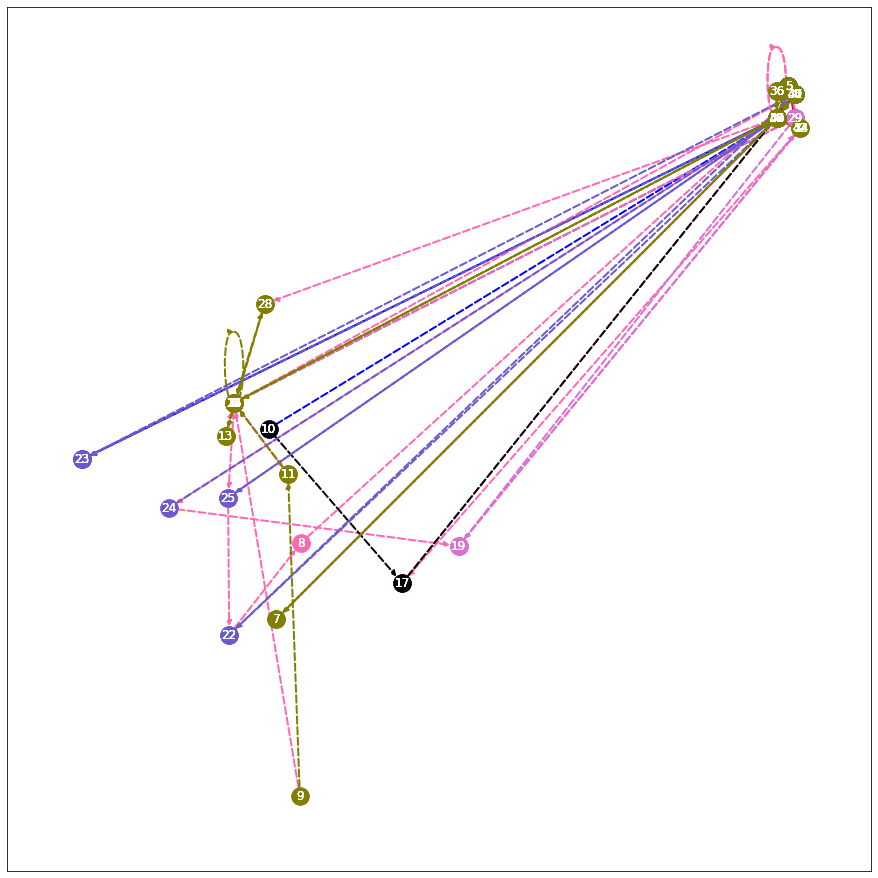

In [12]:
#@title Solution
# Create Routing Model Manager
data = DataProblem()
manager = pywrapcp.RoutingIndexManager(data.num_locations, data.num_vehicles, [x for x in range(5)], [5] * 5)
print(f"number of locations: {manager.GetNumberOfNodes()}")
print(f"number of vehicles: {manager.GetNumberOfVehicles()}")
assert manager.GetNumberOfVehicles() == len(data.starts)
assert manager.GetNumberOfVehicles() == len(data.ends)
routing = pywrapcp.RoutingModel(manager)
dist_evaluator = CreateDistanceEvaluator(data, manager)
dist_evaluator.define_total_cost(data, routing, manager)

distance_callback_index = routing.RegisterTransitCallback(dist_evaluator.distance_evaluator)
add_distance_dimension(routing, distance_callback_index, data, manager)

demand_evaluator = CreateDemandEvaluator(data, manager).demand_evaluator
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_evaluator)
add_capacity_constraints(routing, data, demand_callback_index, manager)

time_evaluator = CreateTimeEvaluator(data, manager).time_evaluator
time_callback_index = routing.RegisterTransitCallback(time_evaluator)
add_time_window_constraints(routing, data, time_callback_index, manager)

allow_dropping(routing, data, manager)

setup_PDP(routing, data, manager)

search_parameters = pywrapcp.DefaultRoutingSearchParameters()

# search_parameters.first_solution_strategy = (
#     routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
# search_parameters.local_search_metaheuristic = (
#         routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.log_search = True 
# search_parameters.time_limit.seconds = 10
# search_parameters.time_limit.seconds = 1


# 1)First Solution Heuristic


search_parameters.first_solution_strategy = (
   routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)
search_parameters.log_search = True
search_parameters.time_limit.seconds = 20
search_parameters.time_limit.seconds = 120


# 2).Guided Local Search Heuristics


# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
# search_parameters.log_search = True
# search_parameters.time_limit.seconds = 20


# 3).Simulated Annealing Heuristics


# search_parameters.local_search_metaheuristic = (
#     routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
# search_parameters.time_limit.seconds = 60

# 4).TABU_SEARCH Heuristics


# search_parameters.local_search_metaheuristic = (
#  routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
# search_parameters.log_search = True
# search_parameters.time_limit.seconds = 60

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print("Solution found !\n")

    printer = ConsolePrinter(data, manager, routing, solution)
    printer.print()
    # DrawNetworks(data)
    DrawNetwork(data)
    plt.show()

else:
    print("No Solution found !\n")
